In [1]:
#Packages for data loading, data analysis, and data preparation
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
import sweetviz as sv

#Packages for model evaluation and classification models
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score

from pickle import dump
from pickle import load
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('label.csv')

In [3]:
df.head()

,Gndr,State_Abrvtn,RUCA,Type,Place_Of_Srvc,Tot_Bene_Day_Srvcs,Tot_Srvcs,Avg_Sbmtd_Chrg,Avg_Mdcr_Stdzd_Amt,eligibility
0,1,25,1,44,3,0.086846,0.038814,-0.270365,-0.180985,0
1,1,19,1,73,0,0.138674,0.135430,-0.241973,-0.414999,0
2,1,41,1,7,1,-0.013540,-0.031064,-0.223454,0.001080,0
3,0,41,1,63,2,-0.039419,-0.057107,-0.377797,-0.360670,0
4,1,9,1,30,0,-0.039454,-0.057134,-0.151161,-0.226828,0


In [4]:
df.eligibility.value_counts()

0    1114151
1       9438
Name: eligibility, dtype: int64

In [5]:
df.shape

(1123589, 10)

In [6]:
df.eligibility.value_counts(normalize=True).mul(100).round(2)

0    99.16
1     0.84
Name: eligibility, dtype: float64

# 5% Validation

In [7]:
df_val, X_test, y_train, y_test = train_test_split(df, df.eligibility, test_size=0.95, stratify = df.eligibility, random_state=42)

In [8]:
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(df_val.drop(columns = ['eligibility'], axis = 1), df_val.eligibility, test_size=0.2, random_state=42)

# 10%Train and Test

Spliting 10% for further spliting into train and test 80%

In [9]:
df_val_10, X_test, y_train, y_test = train_test_split(df, df.eligibility, test_size=0.90, stratify = df.eligibility, random_state=42)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df_val_10.drop(columns = ['eligibility'], axis = 1), df_val_10.eligibility, test_size=0.2, random_state=42)

Models

In [11]:
models = []
models.append(('LR', LogisticRegression(solver = 'saga', max_iter = 5000)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('NB', GaussianNB()))
models.append(('GBM', GradientBoostingClassifier()))
models.append(('AB', AdaBoostClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))

In [12]:
%%time
scoring = ('recall', 'accuracy')
num_folds = 5
results_recall = []
results_accuracy = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_validate(model, X_train_val, y_train_val, cv=kfold, scoring=scoring)
    results_recall.append(cv_results['test_recall'])
    results_accuracy.append(cv_results['test_accuracy'])
    
    names.append(name)
    
    #print(name, cv_results)

C:\Users\ronal\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ronal\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ronal\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ronal\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True o

Wall time: 3min 29s


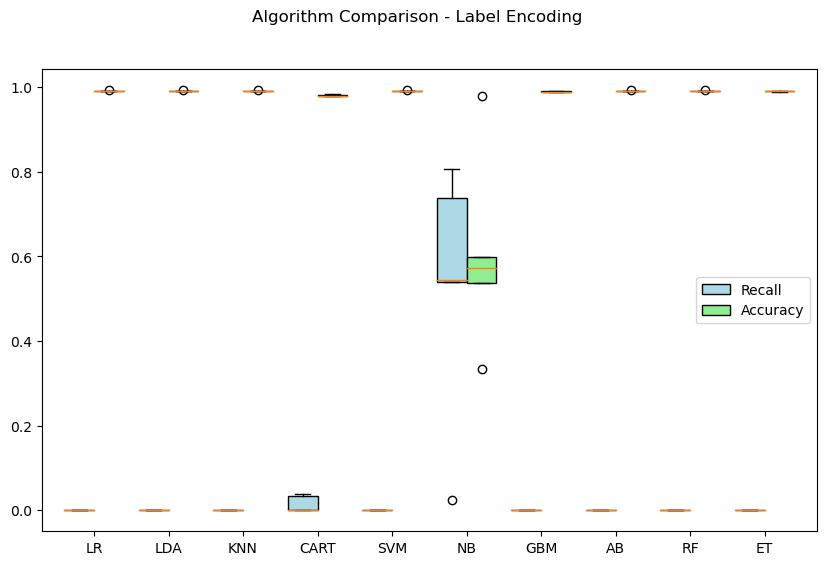

In [13]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison - Label Encoding')
ax = fig.add_subplot(111)
boxplot_recall = ax.boxplot(results_recall,positions=np.arange(len(names)) - 0.2, widths=0.4, patch_artist=True )
boxplot_accuracy = ax.boxplot(results_accuracy, positions=np.arange(len(names)) + 0.2, widths=0.4, patch_artist=True)

colors = ['lightblue', 'lightgreen']  # Define colors for clarity
for boxplot, color in zip([boxplot_recall, boxplot_accuracy], colors):
    for box in boxplot['boxes']:
        box.set_facecolor(color)

ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names)

ax.legend([boxplot_recall['boxes'][0], boxplot_accuracy['boxes'][0]], ['Recall', 'Accuracy'])

fig.set_size_inches(10,6)
pyplot.show()

# Under-sampling

In [14]:
df_under = pd.concat([X_train_val, y_train_val], axis=1)

In [15]:
df_under.eligibility.value_counts()

0    44553
1      390
Name: eligibility, dtype: int64

In [16]:
fraud_df = df_under.loc[df['eligibility'] == 1]
non_fraud_df = df_under.loc[df['eligibility'] == 0][:390]

In [17]:
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])
# Shuffle dataframe rows
df_new = normal_distributed_df.sample(frac=1, random_state=42)
# split out validation dataset for the end
y_train_under= df_new["eligibility"]
X_train_under = df_new.loc[:, df.columns != 'eligibility']

In [18]:
df_new.eligibility.value_counts()

0    390
1    390
Name: eligibility, dtype: int64

In [19]:
%%time
scoring = ('recall', 'accuracy')
num_folds = 5
results_recall = []
results_accuracy = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_validate(model, X_train_under, y_train_under, cv=kfold, scoring=scoring)
    results_recall.append(cv_results['test_recall'])
    results_accuracy.append(cv_results['test_accuracy'])
    
    names.append(name)
    
    print(name, ': Completed')

LR : Completed
LDA : Completed
KNN : Completed
CART : Completed


C:\Users\ronal\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\ronal\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

SVM : Completed
NB : Completed
GBM : Completed
AB : Completed
RF : Completed
ET : Completed
Wall time: 3.56 s


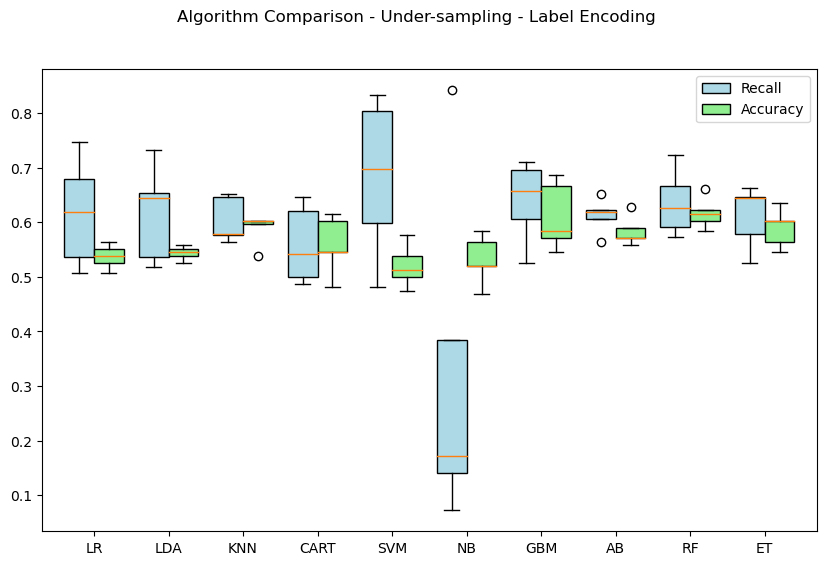

In [20]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison - Under-sampling - Label Encoding')
ax = fig.add_subplot(111)
boxplot_recall = ax.boxplot(results_recall,positions=np.arange(len(names)) - 0.2, widths=0.4, patch_artist=True )
boxplot_accuracy = ax.boxplot(results_accuracy, positions=np.arange(len(names)) + 0.2, widths=0.4, patch_artist=True)

colors = ['lightblue', 'lightgreen']  # Define colors for clarity
for boxplot, color in zip([boxplot_recall, boxplot_accuracy], colors):
    for box in boxplot['boxes']:
        box.set_facecolor(color)

ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names)

ax.legend([boxplot_recall['boxes'][0], boxplot_accuracy['boxes'][0]], ['Recall', 'Accuracy'])

fig.set_size_inches(10,6)
pyplot.show()

# Over-sampling

In [21]:
smote = SMOTE(random_state=42)
X_train_smote_val, y_train_smote_val = smote.fit_resample(X_train_val, y_train_val)

In [22]:
y_train_smote_val.value_counts()

0    44553
1    44553
Name: eligibility, dtype: int64

In [23]:
%%time
scoring = ('recall', 'accuracy')
num_folds = 5
results_recall = []
results_accuracy = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_validate(model, X_train_smote_val, y_train_smote_val, cv=kfold, scoring=scoring)
    results_recall.append(cv_results['test_recall'])
    results_accuracy.append(cv_results['test_accuracy'])
    
    names.append(name)
    
    print(name, ': Completed')

LR : Completed
LDA : Completed


C:\Users\ronal\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\ronal\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

KNN : Completed
CART : Completed
SVM : Completed
NB : Completed
GBM : Completed
AB : Completed
RF : Completed
ET : Completed
Wall time: 31min 32s


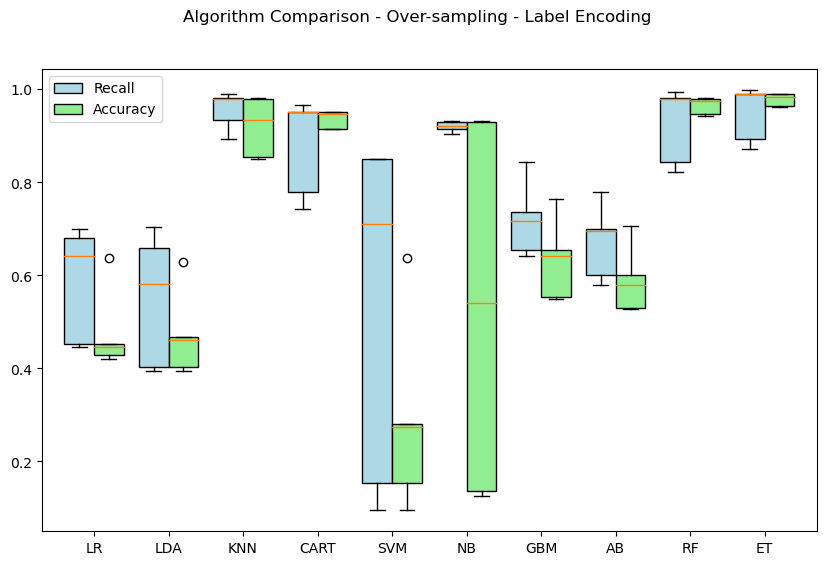

In [24]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison - Over-sampling - Label Encoding')
ax = fig.add_subplot(111)
boxplot_recall = ax.boxplot(results_recall,positions=np.arange(len(names)) - 0.2, widths=0.4, patch_artist=True )
boxplot_accuracy = ax.boxplot(results_accuracy, positions=np.arange(len(names)) + 0.2, widths=0.4, patch_artist=True)

colors = ['lightblue', 'lightgreen']  # Define colors for clarity
for boxplot, color in zip([boxplot_recall, boxplot_accuracy], colors):
    for box in boxplot['boxes']:
        box.set_facecolor(color)

ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names)

ax.legend([boxplot_recall['boxes'][0], boxplot_accuracy['boxes'][0]], ['Recall', 'Accuracy'])

fig.set_size_inches(10,6)
pyplot.show()

# Best model - Under-sampling

In [25]:
df_under = pd.concat([X_train, y_train], axis=1)

In [26]:
df_under.eligibility.value_counts()

0    89107
1      779
Name: eligibility, dtype: int64

In [27]:
fraud_df = df_under.loc[df['eligibility'] == 1]
non_fraud_df = df_under.loc[df['eligibility'] == 0][:779]

In [28]:
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])
# Shuffle dataframe rows
df_new = normal_distributed_df.sample(frac=1, random_state=42)
# split out validation dataset for the end

X_train_under = df_new.loc[:, df.columns != 'eligibility']
y_train_under= df_new["eligibility"]

In [29]:
model = KNeighborsClassifier()
model.fit(X_train_under, y_train_under)

predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

C:\Users\ronal\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


              precision    recall  f1-score   support

           0       0.99      0.53      0.69     22307
           1       0.01      0.59      0.02       165

    accuracy                           0.53     22472
   macro avg       0.50      0.56      0.36     22472
weighted avg       0.99      0.53      0.69     22472



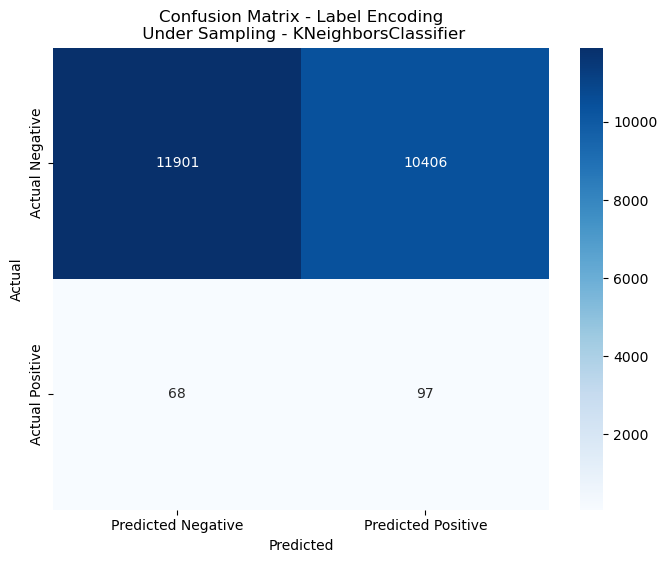

In [30]:
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Label Encoding\n Under Sampling - {type(model).__name__}')
plt.show()

In [31]:
model = RandomForestClassifier()
model.fit(X_train_under, y_train_under)

predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      0.60      0.75     22307
           1       0.01      0.66      0.02       165

    accuracy                           0.60     22472
   macro avg       0.50      0.63      0.38     22472
weighted avg       0.99      0.60      0.74     22472



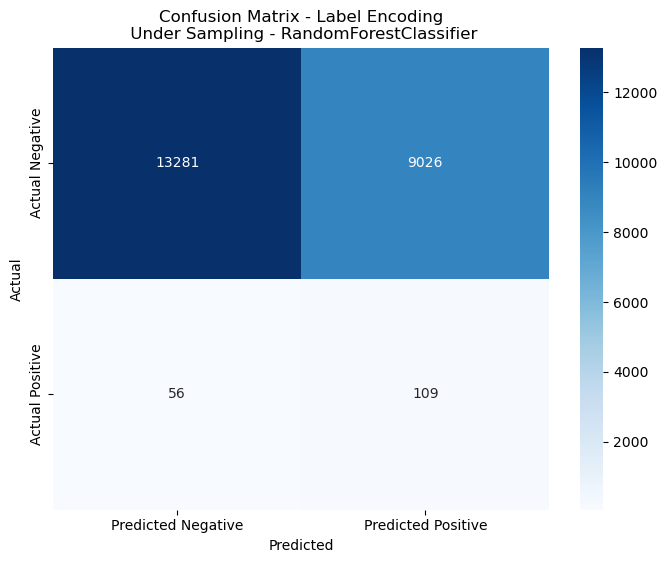

In [32]:
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Label Encoding\n Under Sampling - {type(model).__name__}')
plt.show()

In [33]:
model = GradientBoostingClassifier()
model.fit(X_train_under, y_train_under)

predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      0.58      0.73     22307
           1       0.01      0.70      0.02       165

    accuracy                           0.58     22472
   macro avg       0.50      0.64      0.38     22472
weighted avg       0.99      0.58      0.73     22472



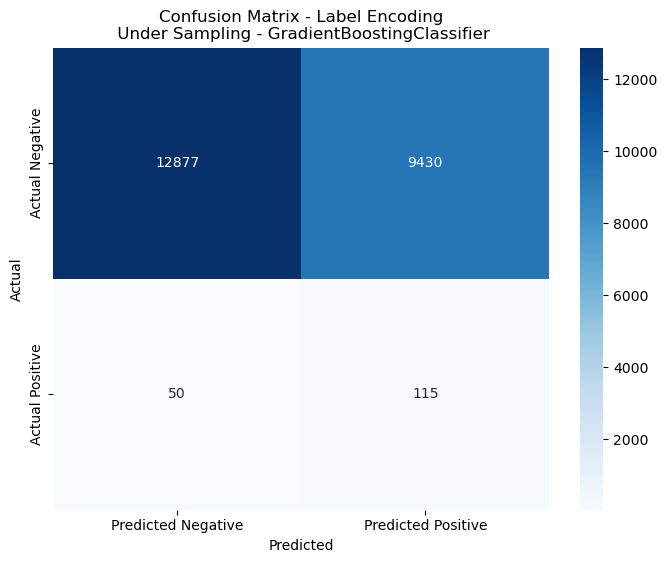

In [34]:
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Label Encoding\n Under Sampling - {type(model).__name__}')
plt.show()

In [35]:
model = SVC()
model.fit(X_train_under, y_train_under)

predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.99      0.36      0.53     22307
           1       0.01      0.72      0.02       165

    accuracy                           0.36     22472
   macro avg       0.50      0.54      0.27     22472
weighted avg       0.99      0.36      0.52     22472



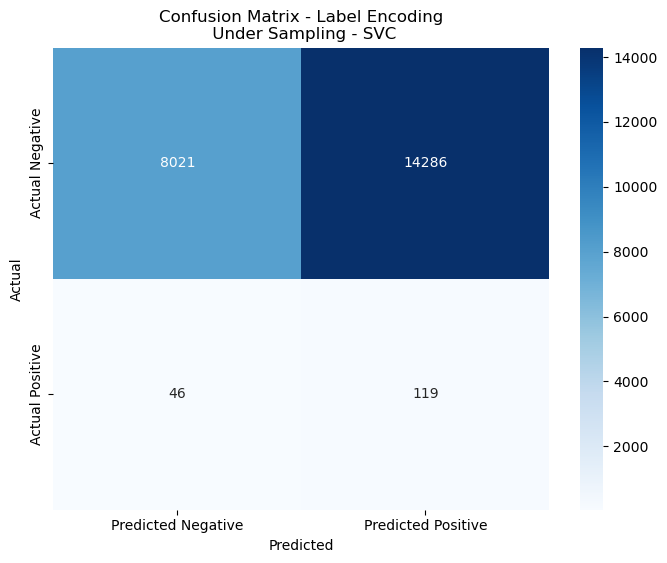

In [36]:
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Label Encoding\n Under Sampling - {type(model).__name__}')
plt.show()

# Best model - Over-sampling

In [56]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [38]:
model = KNeighborsClassifier()
model.fit(X_train_smote, y_train_smote)

predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

C:\Users\ronal\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


              precision    recall  f1-score   support

           0       0.99      0.90      0.94     22307
           1       0.01      0.13      0.02       165

    accuracy                           0.89     22472
   macro avg       0.50      0.51      0.48     22472
weighted avg       0.99      0.89      0.94     22472



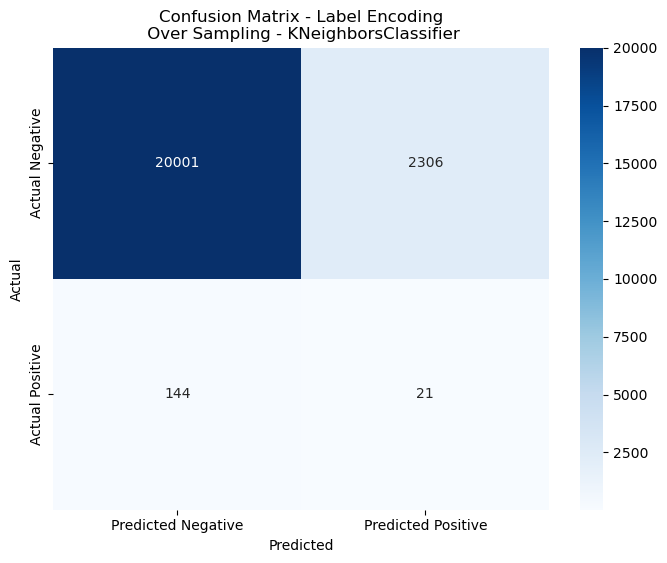

In [39]:
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Label Encoding\n Over Sampling - {type(model).__name__}')
plt.show()

In [40]:
model = SVC()
model.fit(X_train_smote, y_train_smote)

predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.99      0.61      0.76     22307
           1       0.01      0.47      0.02       165

    accuracy                           0.61     22472
   macro avg       0.50      0.54      0.39     22472
weighted avg       0.99      0.61      0.75     22472



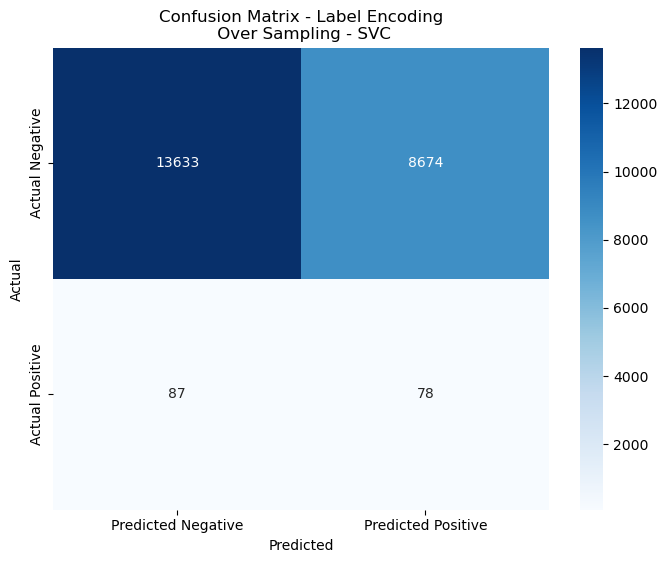

In [41]:
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Label Encoding\n Over Sampling - {type(model).__name__}')
plt.show()

In [42]:
model = GradientBoostingClassifier()
model.fit(X_train_smote, y_train_smote)

predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      0.65      0.79     22307
           1       0.01      0.58      0.02       165

    accuracy                           0.65     22472
   macro avg       0.50      0.61      0.40     22472
weighted avg       0.99      0.65      0.78     22472



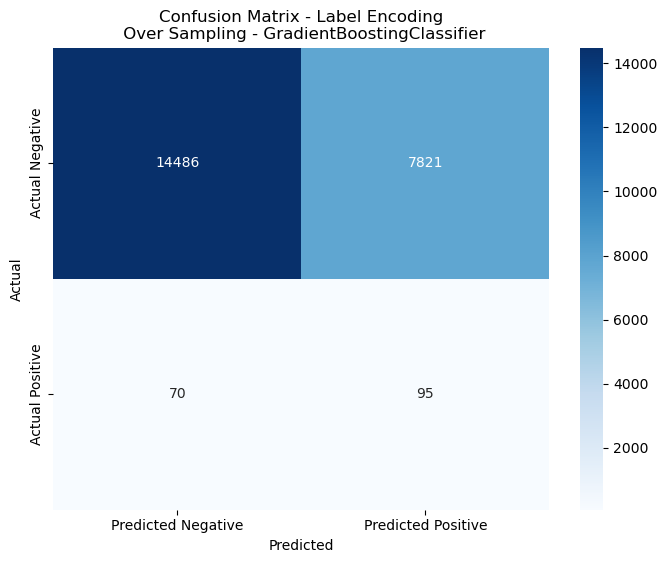

In [43]:
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Label Encoding\n Over Sampling - {type(model).__name__}')
plt.show()

In [44]:
model = RandomForestClassifier()
model.fit(X_train_smote, y_train_smote)

predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     22307
           1       0.01      0.05      0.02       165

    accuracy                           0.96     22472
   macro avg       0.50      0.51      0.50     22472
weighted avg       0.99      0.96      0.97     22472



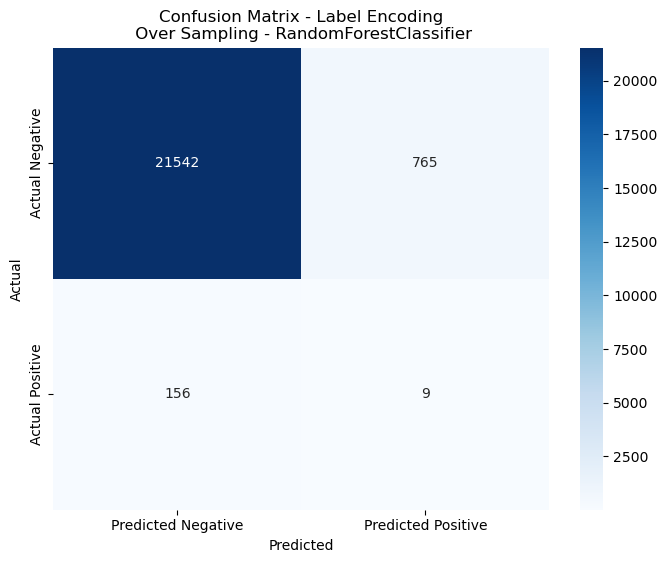

In [45]:
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Label Encoding\n Over Sampling - {type(model).__name__}')
plt.show()

In [46]:
model = AdaBoostClassifier()
model.fit(X_train_smote, y_train_smote)

predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.99      0.62      0.77     22307
           1       0.01      0.56      0.02       165

    accuracy                           0.62     22472
   macro avg       0.50      0.59      0.39     22472
weighted avg       0.99      0.62      0.76     22472



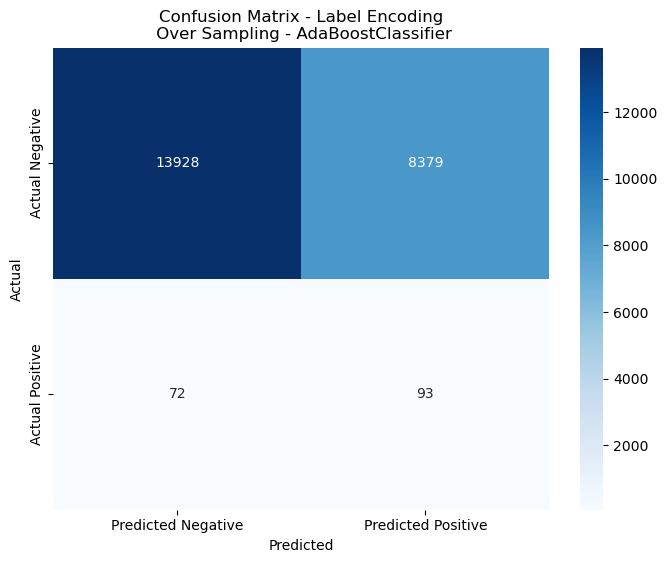

In [47]:
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Label Encoding\n Over Sampling - {type(model).__name__}')
plt.show()

In [48]:
model = ExtraTreesClassifier()
model.fit(X_train_smote, y_train_smote)

predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     22307
           1       0.01      0.05      0.02       165

    accuracy                           0.97     22472
   macro avg       0.50      0.51      0.50     22472
weighted avg       0.99      0.97      0.98     22472



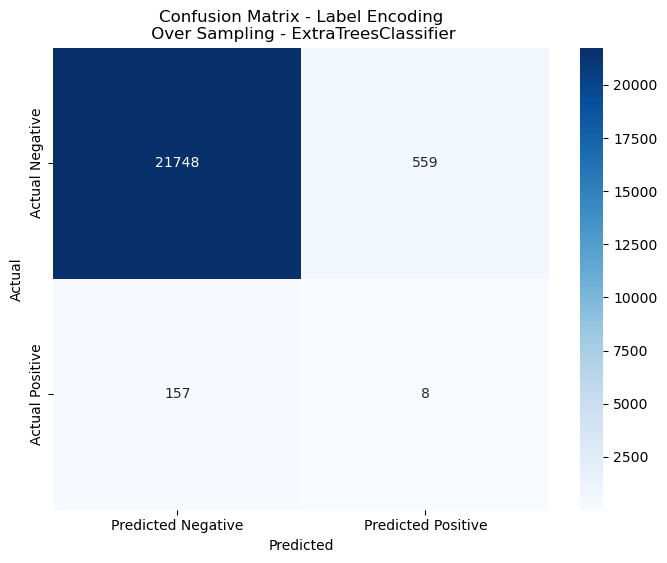

In [49]:
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Label Encoding\n Over Sampling - {type(model).__name__}')
plt.show()

In [57]:
model = DecisionTreeClassifier()
model.fit(X_train_smote, y_train_smote)

predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.99      0.92      0.95    111414
           1       0.01      0.14      0.03       945

    accuracy                           0.91    112359
   macro avg       0.50      0.53      0.49    112359
weighted avg       0.98      0.91      0.95    112359



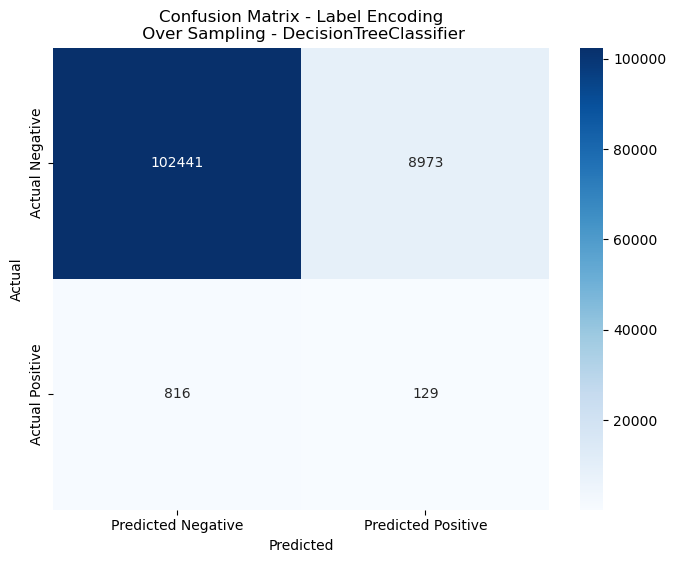

In [58]:
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Label Encoding\n Over Sampling - {type(model).__name__}')
plt.show()

# 50%Train and Test

In [50]:
df_val_50, X_test, y_train, y_test = train_test_split(df, df.eligibility, test_size=0.5, stratify = df.eligibility, random_state=42)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(df_val_50.drop(columns = ['eligibility'], axis = 1), df_val_50.eligibility, test_size=0.2, random_state=42)

In [52]:
df_under = pd.concat([X_train, y_train], axis=1)
count = len(df_under[df_under.eligibility == 1])
fraud_df = df_under.loc[df['eligibility'] == 1]
non_fraud_df = df_under.loc[df['eligibility'] == 0][:count]

In [53]:
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])
# Shuffle dataframe rows
df_new = normal_distributed_df.sample(frac=1, random_state=42)
# split out validation dataset for the end
y_train_under= df_new["eligibility"]
X_train_under = df_new.loc[:, df.columns != 'eligibility']

In [54]:
model = GradientBoostingClassifier()
model.fit(X_train_under, y_train_under)

predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      0.58      0.74    111414
           1       0.01      0.74      0.03       945

    accuracy                           0.59    112359
   macro avg       0.51      0.66      0.38    112359
weighted avg       0.99      0.59      0.73    112359



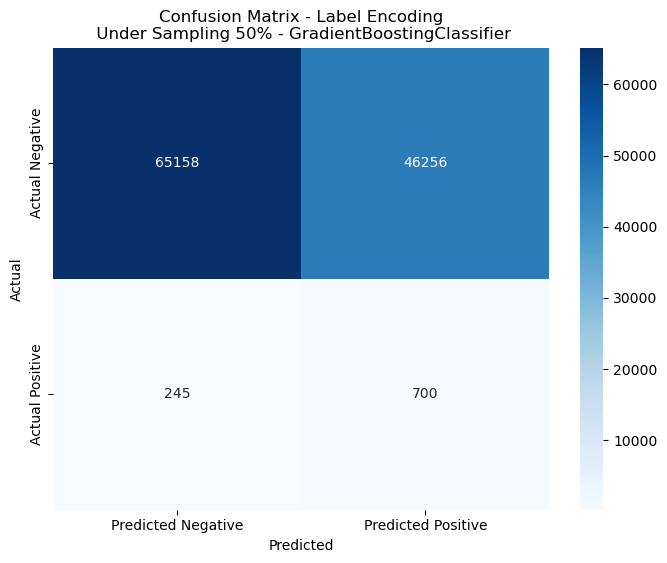

In [55]:
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Label Encoding\n Under Sampling 50% - {type(model).__name__}')
plt.show()